<h1>IS4242 Group Project</h1>

<b>Import necessary libraries</b>

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

'''
Ensure that you are in the root folder of all the fold folders and target files
read_text(fold_name):
    fold_name: this is the name of the fold you want to read ALL patient files of. It will be read into a 2 dimensional
    list. If you would like to retrieve just the first patient instead, you will need to change the line 
    "txt_all.extend(txt[1:])" to "txt_all.append(txt[1:])" and you will be to use "read_text(fold1.txt)[0]" to retrieve
    the relevant patient's data
read_ans(file_name):
    file_name: this is the name of the file you want to read ALL targets of. It will be read into a 2 dimensional
    list. To retrieve the first patient's target: read_ans(ans.csv)[0]
put_single_into_dataframe(txt): This functions takes in 2 dimensional list ie the output of read_text(fold1.txt) 
put_multiple_into_dataframe(txt): Multiple is for using it with the output of read_text after you wanted to change it to append
'''

In [25]:
def read_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
                recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
                txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
                txt_all.extend(txt[1:]) # skip the parameter list
    return txt_all

def read_one_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
            recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
            txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
            txt_all.append(txt[1:]) # skip the parameter list
    return txt_all

def read_ans(file_name):
    txt_all = list()
    with open(file_name, 'r') as fp: # opens the csv file
        txt = fp.readlines() 
    for i in range(1, len(txt)): # similar to above read_text
        record_id, length_of_stay, hospital_death = txt[i].rstrip('\n').split(',')
        txt_all.append([record_id, length_of_stay, hospital_death])
    return txt_all

def put_multiple_into_dataframe(txt_all):
    df = pd.DataFrame()
    for i in txt_all:
        df2 = pd.DataFrame(i, columns=['recordid', 'time', 'parameter', 'value'])
        df = df.append(df2, ignore_index=True)
    return df

def put_single_into_dataframe(txt_all):
    df = pd.DataFrame(txt_all, columns=['recordid', 'time', 'parameter', 'value'])
    return df

def get_X_add_ready(X_add, stat):
    X_add = X_add.reset_index()
    X_add = X_add.pivot(index='recordid', columns='parameter', values='value')
    X_add = X_add.drop(stat_feat, axis = 1) 
#     X_add = X_add.drop(['RecordID'], axis = 1) 
    X_add.columns = [x+stat for x in X_add.columns]
    X_add = X_add.reset_index()
    return X_add

<h2>1. Data Exploration</h2>

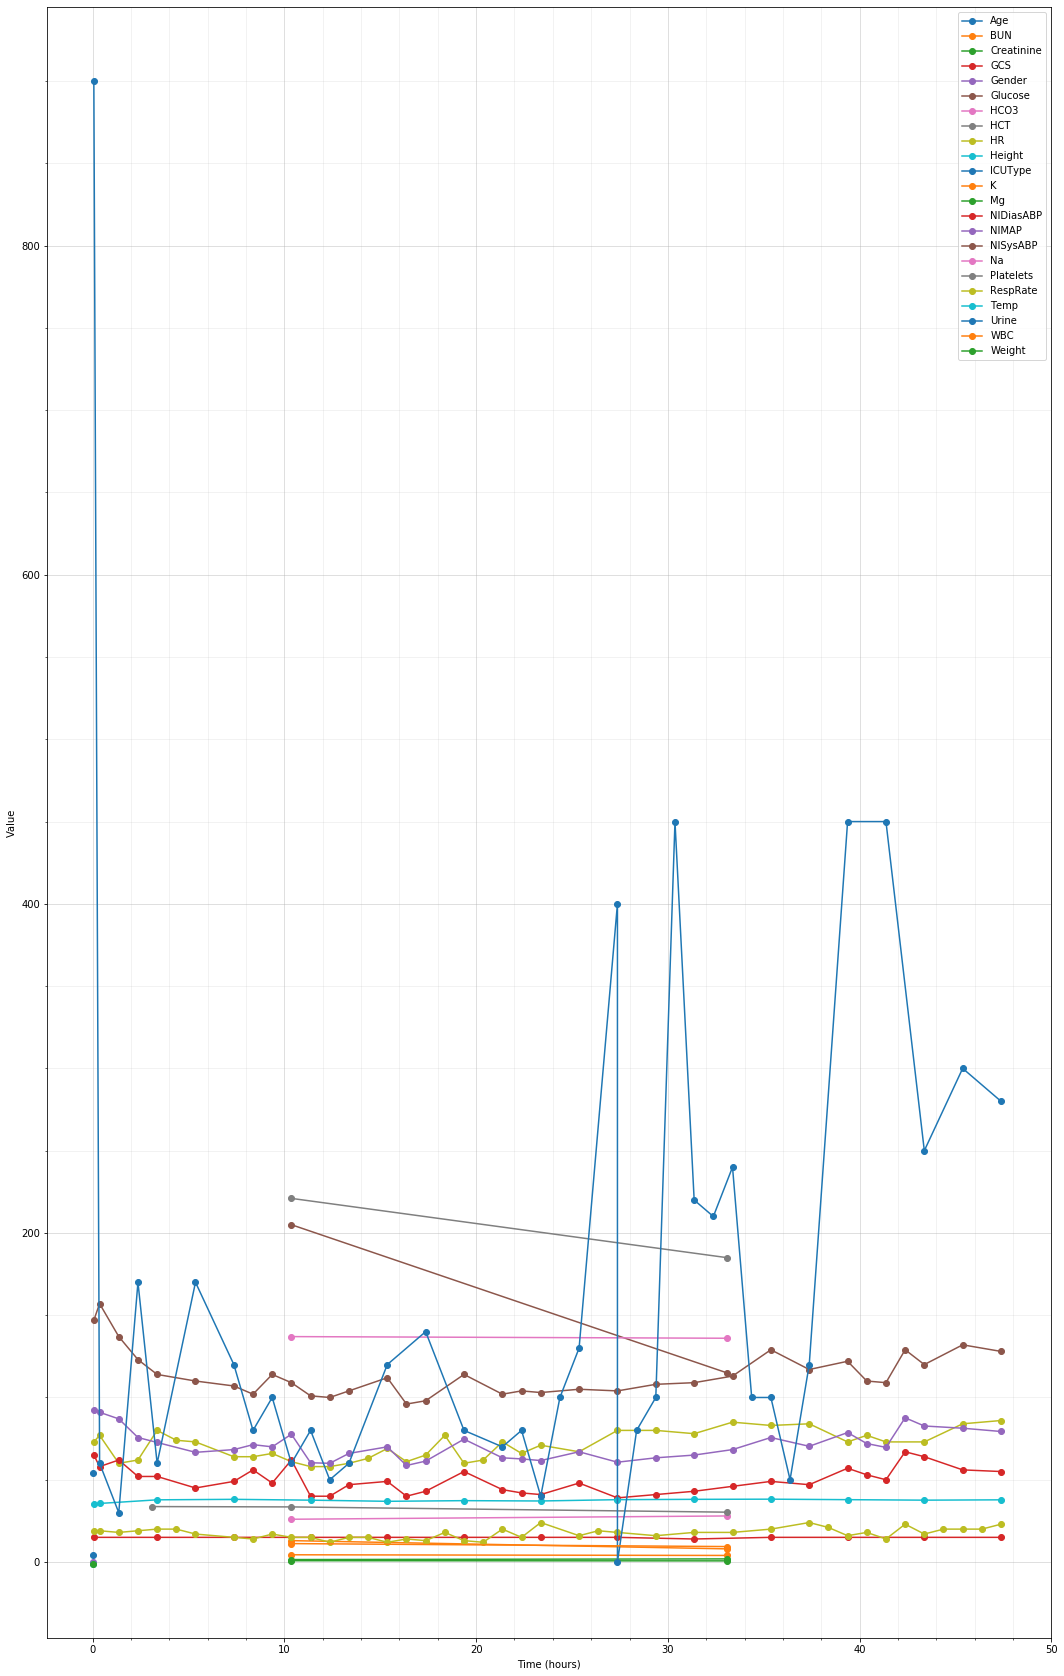

In [28]:
p1 = read_one_text("../Project_Data/Fold1")[0]
p1df = pd.DataFrame(p1, columns=['recordid', 'time', 'parameter', 'value'])
df_1 = p1df.drop('recordid', axis=1)
df_1.drop(df_1.index[:1], inplace=True)
# df_1

df_1['value'] = pd.to_numeric(df_1['value'])
df_1.time = df_1.time.astype('str')
df_1['time'] = df_1['time'].str.replace(':', '.')
df_1['time'] = pd.to_numeric(df_1['time'])
df_1['time_value'] = list(zip(df_1.time, df_1.value))
df_2 = df_1.groupby('parameter').time_value.apply(lambda x: x.unique().tolist())

major_ticks = np.arange(0, 51, 10)
minor_ticks = np.arange(0, 49, 2)
fig = plt.figure(figsize=(18, 30))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_2)):
    testList2 = [(elem1, elem2) for elem1, elem2 in df_2[i]]
    zip(*testList2)
    plt.plot(*zip(*testList2), marker='o', label=df_2.index[i])
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.legend(loc='upper right')
# plt.xlim(xmin=0.0)
# plt.ylim(ymin=0.0)
ax.minorticks_on()
ax.set_xticks(minor_ticks, minor=True)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# ax.tick_params(which = 'both', direction = 'out')
plt.show()

In [3]:
df_feat = pd.DataFrame()
numberOfFolds = 0
for i, name in enumerate(["Fold1"]): # what folds do you want to use?
    str = "../Project_Data/"
    str += name
    df_feat = df_feat.append(put_single_into_dataframe(read_text(str)))
    numberOfFolds = (i+1)
numberOfRows = numberOfFolds*1000
df_feat.head()

,recordid,time,parameter,value
0,132539,00:00,RecordID,132539
1,132539,00:00,Age,54
2,132539,00:00,Gender,0
3,132539,00:00,Height,-1
4,132539,00:00,ICUType,4


In [4]:
# Reading Target
df_target = pd.DataFrame(read_ans('../Project_Data/Fold1_Outcomes.csv'), columns=['recordid', 'days_in_hospital', 'mortality'])
df_target.head()

,recordid,days_in_hospital,mortality
0,132539,5,0
1,132540,8,0
2,132541,19,0
3,132543,9,0
4,132545,4,0


In [5]:

bin_feat = ['MechVent']
num_feat = ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol',
           'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT',
           'HR', 'K', 'Lactate', 'Mg', 'MAP', 'NA', 'NIDiasABP', 'NIMAP',
           'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate', 'SaO2',
           'SysABP', 'Temp', 'Tropl', 'TropT', 'Urine', 'WBC', 'Weight']

print("Number of record ids:", len(df_feat['recordid'].unique()))
unique_count = df_feat['parameter'].value_counts()/numberOfRows
print(unique_count)

Number of record ids: 1000
HR             57.027
MAP            36.092
SysABP         35.979
DiasABP        35.955
Urine          34.208
Weight         33.679
NISysABP       24.457
NIDiasABP      24.424
NIMAP          24.088
Temp           21.204
GCS            15.214
RespRate       13.775
FiO2            7.815
MechVent        7.596
pH              5.770
PaO2            5.496
PaCO2           5.490
HCT             4.626
K               3.708
Creatinine      3.573
Platelets       3.566
BUN             3.547
HCO3            3.479
Mg              3.468
Na              3.462
Glucose         3.338
WBC             3.286
SaO2            1.985
Lactate         1.924
Age             1.000
ICUType         1.000
Height          1.000
Gender          1.000
RecordID        1.000
Bilirubin       0.858
ALT             0.857
AST             0.857
ALP             0.833
Albumin         0.617
TroponinT       0.566
TroponinI       0.130
Cholesterol     0.077
Name: parameter, dtype: float64


<h2>Analysis of Features</h2>
<p>The data above shows the average number of times a variable observed per patient. Based on the data above and the feature description we classify the features into these categories:
<ul>
    <li>General Descriptors (static data) that are collected when the patient is admitted to the ICU. Weight is not included as weight are measured multiple times as a time series data. Each of the descriptors will be included as a feature into the model.</li>
    <li>Rare features: measured on average less than one time per patient (less than 1.0). We use the <u>existence</u> of these measurements for each patient as a feature.</li>
    <li>Features that measured often or more that one time per patient (more than 1.0). Calculate the hourly average of each measurements and put them into 48 columns. <i>Example, average HR on the first hour to HR_1, average HR on the second hour to HR_2, and so on.</i></li>
</ul>
</p>


In [6]:
stat_feat = ['Age', 'Gender', 'Height', 'ICUType', 'RecordID'] #General Descriptors
rare_feat = []
nor_feat = []
for index, value in unique_count.items():
    if value < 1.0:
        rare_feat.append(index)
    elif index not in stat_feat:
        nor_feat.append(index)
rare_feat.append("MechVent")
print("Rare features", rare_feat)
print("Normal features", nor_feat)

Rare features ['Bilirubin', 'ALT', 'AST', 'ALP', 'Albumin', 'TroponinT', 'TroponinI', 'Cholesterol', 'MechVent']
Normal features ['HR', 'MAP', 'SysABP', 'DiasABP', 'Urine', 'Weight', 'NISysABP', 'NIDiasABP', 'NIMAP', 'Temp', 'GCS', 'RespRate', 'FiO2', 'MechVent', 'pH', 'PaO2', 'PaCO2', 'HCT', 'K', 'Creatinine', 'Platelets', 'BUN', 'HCO3', 'Mg', 'Na', 'Glucose', 'WBC', 'SaO2', 'Lactate']


In [7]:
# your code to produce test and train data
df = df_feat.copy()

<h2>Creation of Data Matrices</h2>
<p>We create 3 different matrices to convert temporal data into a matrix that is a single feature vector per patient </p>
<ul> 
    <li>First, in the cell below, we create a matrix that generalises a patient's attributes across the whole 48 hours, such as his max BUN measurement over the 48 hours. </li>
    <li></li>
    <li></li>
</ul>

In [8]:
df['value'] = pd.to_numeric(df['value'])
temp_df = df.loc[df['time'] == '00:00', :].copy() # get all the variables at time 0
temp_df = temp_df.loc[temp_df['parameter'].isin(stat_feat)] # prune the dataframe to only those static variables
temp_df = temp_df.pivot(index='recordid', columns='parameter', values='value') 
temp_df = temp_df.reset_index()
for i in temp_df: # for loop to change all the -1 values for static variables into np.nan
    idx = temp_df.index[temp_df[i] == -1].tolist()
    for j in idx:
        temp_df.loc[j, i] = np.nan
final_df = temp_df.copy()

# Dealing with rare_feat
d = df_feat.groupby(['recordid', 'parameter'])[['value']].count()
def specialFeature(special):
    id = []
    for index, row in d.iterrows():
        if index[1] == special:
            id.append(index[0])
    return id
for x in rare_feat:
    id = specialFeature(x)
    final_df[x] = 0
    for i in id:
        for row in final_df.recordid:
            if row == i:
                final_df.loc[final_df.loc[final_df['recordid'] == row].index[0], x] = 1

final_df = final_df.drop(["RecordID"],axis=1)

# Getting the different attributes
pd.set_option('display.max_columns', 500)
temp_df = df.drop(df.index[df['parameter'].isin(rare_feat)].tolist())
temp_df = temp_df.groupby(['recordid', 'parameter'])[['value']]
for i in ['min', 'max', 'mean']: # the different parameters we will use
    if (i=='min'):
        X_add = temp_df.min() # get the min of each parameter
        X_add = get_X_add_ready(X_add, '_min')
        final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
    elif (i=='max'):
        X_add = temp_df.max() # get the max of each parameter
        X_add = get_X_add_ready(X_add, '_max')
        final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
    elif (i=='mean'):
        X_add = temp_df.mean() # get the mean of each parameter
        X_add = get_X_add_ready(X_add, '_mean')
        final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe

# dealing with ICUType categorical
one_hot = pd.get_dummies(final_df['ICUType'])
meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
final_df = final_df.merge(one_hot, left_index=True, right_index=True)
final_df = final_df.drop('ICUType', axis=1)

final_df.head()

,recordid,Age,Gender,Height,Bilirubin,ALT,AST,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,BUN_min,Creatinine_min,DiasABP_min,FiO2_min,GCS_min,Glucose_min,HCO3_min,HCT_min,HR_min,K_min,Lactate_min,MAP_min,Mg_min,NIDiasABP_min,NIMAP_min,NISysABP_min,Na_min,PaCO2_min,PaO2_min,Platelets_min,RespRate_min,SaO2_min,SysABP_min,Temp_min,Urine_min,WBC_min,Weight_min,pH_min,BUN_max,Creatinine_max,DiasABP_max,FiO2_max,GCS_max,Glucose_max,HCO3_max,HCT_max,HR_max,K_max,Lactate_max,MAP_max,Mg_max,NIDiasABP_max,NIMAP_max,NISysABP_max,Na_max,PaCO2_max,PaO2_max,Platelets_max,RespRate_max,SaO2_max,SysABP_max,Temp_max,Urine_max,WBC_max,Weight_max,pH_max,BUN_mean,Creatinine_mean,DiasABP_mean,FiO2_mean,GCS_mean,Glucose_mean,HCO3_mean,HCT_mean,HR_mean,K_mean,Lactate_mean,MAP_mean,Mg_mean,NIDiasABP_mean,NIMAP_mean,NISysABP_mean,Na_mean,PaCO2_mean,PaO2_mean,Platelets_mean,RespRate_mean,SaO2_mean,SysABP_mean,Temp_mean,Urine_mean,WBC_mean,Weight_mean,pH_mean,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
0,132539,54.0,0.0,NaN,0,0,0,0,0,0,0,0,0,8.0,0.7,NaN,NaN,14.0,115.0,26.0,30.3,58.0,4.0,NaN,NaN,1.5,39.0,58.67,96.0,136.0,NaN,NaN,185.0,12.0,NaN,NaN,35.1,0.0,9.4,-1.0,NaN,13.0,0.8,NaN,NaN,15.0,205.0,28.0,33.7,86.0,4.4,NaN,NaN,1.9,67.0,92.33,157.0,137.0,NaN,NaN,221.0,24.0,NaN,NaN,38.2,900.0,11.2,-1.0,NaN,10.500000,0.750000,NaN,NaN,14.923077,160.000000,27.000000,32.500000,70.810811,4.20,NaN,NaN,1.700000,50.147059,71.559118,114.382353,136.500000,NaN,NaN,203.000000,17.428571,NaN,NaN,37.357143,171.052632,10.300000,-1.000000,NaN,0,0,0,1
1,132540,76.0,1.0,175.3,0,0,0,0,0,0,0,0,1,16.0,0.8,32.0,0.4,3.0,105.0,21.0,24.7,65.0,3.5,NaN,43.0,1.9,38.0,49.33,72.0,135.0,33.0,82.0,135.0,NaN,93.0,66.0,34.5,0.0,7.4,76.0,7.34,21.0,1.3,81.0,1.0,15.0,146.0,24.0,30.7,90.0,4.3,NaN,100.0,3.1,67.0,88.33,131.0,139.0,46.0,445.0,226.0,NaN,99.0,138.0,37.9,770.0,13.3,81.6,7.45,18.333333,1.100000,58.897059,0.56,13.333333,125.500000,22.333333,28.655556,80.794118,3.90,NaN,76.940299,2.300000,56.714286,75.308571,112.500000,137.000000,38.857143,210.142857,178.600000,NaN,96.833333,113.411765,36.939130,151.560976,11.266667,80.670588,7.395,0,1,0,0
2,132541,44.0,0.0,NaN,1,1,1,1,1,0,0,0,1,3.0,0.3,52.0,0.4,5.0,119.0,24.0,26.7,57.0,2.3,0.9,72.0,1.3,66.0,83.33,111.0,137.0,33.0,65.0,72.0,NaN,95.0,103.0,36.7,18.0,3.7,56.7,7.47,8.0,0.4,81.0,1.0,8.0,143.0,26.0,29.4,113.0,8.6,1.9,107.0,1.9,95.0,110.00,150.0,140.0,37.0,232.0,113.0,NaN,95.0,148.0,39.0,425.0,6.2,56.7,7.51,4.666667,0.333333,67.125000,0.50,5.923077,134.333333,25.000000,28.460000,83.759259,4.26,1.366667,90.437500,1.720000,79.000000,96.751316,132.263158,138.333333,35.500000,134.500000,89.666667,NaN,95.000000,125.687500,37.800000,124.951220,4.700000,56.700000,7.495,0,0,1,0
3,132543,68.0,1.0,180.3,1,1,1,1,1,0,0,0,0,10.0,0.7,NaN,NaN,14.0,106.0,27.0,36.1,57.0,3.8,NaN,NaN,1.9,45.0,68.33,102.0,137.0,NaN,NaN,284.0,6.0,NaN,NaN,35.1,100.0,7.9,84.6,NaN,23.0,0.9,NaN,NaN,15.0,129.0,28.0,41.3,88.0,4.2,NaN,NaN,2.1,81.0,100.70,140.0,141.0,NaN,NaN,391.0,24.0,NaN,NaN,37.0,700.0,11.5,84.6,NaN,17.666667,0.766667,NaN,NaN,14.944444,117.333333,27.666667,37.442857,70.983333,4.00,NaN,NaN,2.033333,65.051724,83.885517,121.551724,139.333333,NaN,NaN,330.000000,15.457627,NaN,NaN,36.223077,545.833333,9.400000,84.600000,NaN,0,0,1,0
4,132545,88.0,0.0,NaN,0,0,0,0,1,0,0,0,0,25.0,1.0,NaN,NaN,15.0,92.0,18.0,22.6,65.0,3.8,NaN,NaN,1.5,26.0,52.33,105.0,139.0,NaN,NaN,97.0,13.0,NaN,NaN,35.8,16.0,3.8,-1.0,NaN,45.0,1.0,NaN,NaN,15.0,113.0,20.0,32.4,94.0,6.0,NaN,NaN,1.6,96.0,105.70,157.0,140.0,NaN,NaN,109.0,27.0,NaN,NaN,37.8,220.0,4.8,-1.0,NaN,35.000000,1.000000,NaN,NaN,15.000000,102.500000,19.000000,29.550000,74.958333,4.32,NaN,NaN,1.550000,45.720930,74.946512,133.395349,139.500000,NaN,NaN,103.000000,19.166667,NaN,NaN,36.880000,62.131579,4.300000,-1.000000,NaN,0,0,1,0


In [10]:
# Second Matrix

df_static = df.loc[df['time'] == '00:00', :].copy()
static_vars = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
df_static.drop('time', axis=1, inplace=True)
df_static = df_static.loc[df_static['parameter'].isin(static_vars)]
df_static = df_static.groupby(['recordid', 'parameter'])[['value']].last()
df_static.reset_index(inplace=True)
df_static = df_static.pivot(index='recordid', columns='parameter', values='value')
df_static

for c in df_static.columns:
    df_static[c] = pd.to_numeric(df_static[c])

for c in df_static.columns:
    x = df_static[c]
    if c == 'Height':
        idx = x < 0
        df_static.loc[idx, c] = np.nan
    elif c == 'Weight':
        idx = x < 0
        df_static.loc[idx, c] = np.nan
df_static.head()

df2 = df_static.copy()
df2.drop('RecordID', axis=1, inplace=True)
df2.head()

for x in rare_feat:
    id = specialFeature(x)
    df2[x] = 0
    for i in id:
        for row in df2.index:
            if row == i:
                df2.loc[row, x] = 1
df2.head()
normal_feat = nor_feat.copy()
normal_feat.remove('MechVent')
idx = df['parameter'].isin(normal_feat)
df3 = df.loc[idx, :].copy()
df3[['hour','min']] = df3.time.str.split(':', expand=True)
df3["hour"] = pd.to_numeric(df3["hour"])
df3["value"] = pd.to_numeric(df3["value"])
bins = [0, 12, 24, 36, 48]
labels = ['0', '12', '24', '36']
df3 = df3.groupby(['recordid', pd.cut(df3.hour, bins=bins, labels=labels), 'parameter'])[['value']].mean()
df3

for n in normal_feat:    
    df2[n +'0'] = np.nan
    df2[n +'12'] = np.nan
    df2[n +'24'] = np.nan
    df2[n +'36'] = np.nan
df2.head()

for index, row in df3.iterrows():
    recordId = index[0]
    hour = index[1]
    parameter = index[2]
    df2.loc[recordId, parameter+hour] = row["value"]

one_hot = pd.get_dummies(df2['ICUType'])
meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
df2 = df2.merge(one_hot, left_index=True, right_index=True)
df2 = df2.drop('ICUType', axis=1)

df2.head()

,Age,Gender,Height,Weight,Bilirubin,ALT,AST,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,54.0,0.0,NaN,NaN,0,0,0,0,0,0,0,0,0,65.454545,66.090909,78.833333,78.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.000000,86.250000,173.333333,308.333333,NaN,NaN,NaN,NaN,111.700000,104.125000,111.333333,120.875000,50.600000,45.125000,44.333333,56.125000,70.967000,64.792500,66.666667,77.708750,37.833333,37.100000,38.066667,37.766667,15.000000,15.0,14.666667,15.00,16.545455,15.545455,17.857143,19.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.600,NaN,30.30,NaN,4.4,NaN,4.00,NaN,0.8,NaN,0.7,NaN,221.000000,NaN,185.0,NaN,13.0,NaN,8.0,NaN,26.0,NaN,28.0,NaN,1.5,NaN,1.90,NaN,137.0,NaN,136.0,NaN,205.0,NaN,115.0,NaN,11.2,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
132540,76.0,1.0,175.3,76.0,0,0,0,0,0,0,0,0,1,87.076923,80.055556,75.307692,73.636364,75.740741,76.111111,78.384615,80.111111,106.714286,114.222222,119.923077,123.222222,60.892857,56.888889,57.846154,58.222222,158.933333,103.181818,170.714286,187.500000,NaN,80.6,80.6,81.236364,NaN,111.750000,115.142857,107.333333,NaN,57.500000,61.000000,45.666667,NaN,75.580000,79.047143,66.223333,36.688462,37.500000,36.850000,36.800000,10.800000,15.0,14.666667,14.25,NaN,NaN,NaN,NaN,0.56,NaN,NaN,NaN,7.385,7.40,NaN,7.385,226.25,NaN,NaN,111.0,37.0,NaN,NaN,45.0,27.625,28.900000,30.70,29.45,NaN,4.30,NaN,3.5,0.8,1.2,NaN,1.3,190.333333,187.0,NaN,135.0,16.0,18.0,NaN,21.0,21.0,22.0,NaN,24.0,3.1,1.9,NaN,2.1,NaN,139.0,NaN,135.0,NaN,105.0,NaN,146.0,7.4,13.1,NaN,13.3,98.0,97.0,NaN,95.0,NaN,NaN,NaN,NaN,0,1,0,0
132541,44.0,0.0,NaN,56.7,1,1,1,1,1,0,0,0,1,90.000000,83.250000,87.666667,71.166667,NaN,NaN,100.000000,87.250000,NaN,NaN,137.500000,121.750000,NaN,NaN,75.500000,64.333333,111.818182,185.500000,150.000000,58.800000,56.7,56.7,56.7,56.700000,132.812500,136.750000,124.500000,NaN,78.750000,80.583333,76.000000,NaN,96.767500,99.305000,92.163750,NaN,37.825000,37.233333,38.300000,37.833333,7.333333,6.0,5.000000,5.00,NaN,NaN,NaN,NaN,0.75,0.5,0.46,0.4,NaN,7.51,7.49,NaN,NaN,65.0,157.666667,NaN,NaN,37.0,35.0,NaN,28.500,26.700000,28.85,29.40,3.3,8.60,2.85,3.7,0.4,0.3,NaN,0.3,72.000000,84.0,NaN,113.0,8.0,3.0,NaN,3.0,24.0,26.0,NaN,25.0,1.9,1.3,1.85,1.7,137.0,140.0,NaN,138.0,141.0,119.0,NaN,143.0,4.2,3.7,NaN,6.2,NaN,95.0,NaN,NaN,1.3,1.9,0.9,NaN,0,0,1,0
132543,68.0,1.0,180.3,84.6,1,1,1,1,1,0,0,0,0,72.238095,72.500000,63.769231,74.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.000000,400.000000,675.000000,600.000000,84.6,84.6,84.6,84.600000,122.571429,122.090909,117.750000,121.545455,68.285714,61.636364,61.500000,66.181818,86.381429,81.788182,80.250000,84.637273,35.966667,36.433333,36.133333,36.333333,14.500000,15.0,15.000000,15.00,16.100000,14.916667,13.384615,16.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.300,36.850000,36.20,36.30,4.2,NaN,3.80,NaN,0.7,NaN,0.7,NaN,315.000000,NaN,284.0,NaN,2

In [ ]:
# Reading features
# fold1 = put_single_into_dataframe(read_text("../Project_Data/Fold1"))
# fold2 = put_single_into_dataframe(read_text("../Project_Data/Fold2"))
# fold3 = put_single_into_dataframe(read_text("../Project_Data/Fold3"))
# fold4 = put_single_into_dataframe(read_text("../Project_Data/Fold4"))
# df_feat = fold1.copy()
# df_feat = df_feat.append(fold2)
# df_feat = df_feat.append(fold3)
# df_feat = df_feat.append(fold4)
# df_feat.head()